# Lotka-Volterra Hybrid Model

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import tensorflow as tf
from lfm_flow.kernels import LFM1_RBF
from lfm_flow.latentforcemodels import LLFM

np.random.seed(123)
np.set_printoptions(precision=3, suppress=True)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



We consider an LFM reduction of the dynamic system
$$
\begin{aligned}{\frac {dx}{dt}}&=\alpha x-\beta xy,\\{\frac {dy}{dt}}&=\delta xy-\gamma y,
\end{aligned}
$$
to the model
$$
\begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y \\
\frac{dy}{dt} &= Dy(t) + f(t)
\end{align}
$$
This model is straight forward to solve and we have
$$
\begin{align}
    x(t) &= e^{\Omega(t)} x_0, \\
    \Omega(t) &= \alpha t - \beta\int_0^t y(\tau)d\tau
\end{align}
$$



## Data Generation

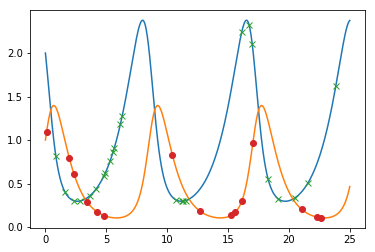

In [2]:
alpha, beta, gamma, delta = (2/3, 4/3, 1, 1)

def dXdt(X, t):
    x, y = X # unpack X
    xdot = alpha*x - beta*x*y
    ydot = delta*x*y - gamma*y
    return [xdot, ydot]

# dense time set
ttd = np.linspace(0., 25., 500)
sol = odeint(dXdt, [2., 1.], ttd)

N1, N2 = (25, 15)
ind1  = np.random.choice(ttd.size-1, replace=True, size=N1)
ind2 = np.random.choice(ttd.size-1, replace=True, size=N2)

#{\displaystyle V=\delta x-\gamma \ln(x)+\beta y-\alpha \ln(y),}

V = delta*sol[:, 0] - gamma*np.log(sol[:, 0]) + beta*sol[:, 1] - alpha*np.log(sol[:, 1])

fig, ax = plt.subplots()
ax.plot(ttd, sol)
ax.plot(ttd[ind1], sol[ind1, 0], 'x')
ax.plot(ttd[ind2], sol[ind2, 1], 'o')
plt.show()

# No feedback training

We first consider training $y(t)$ using *only* the data observed for $y(t)$ using a first order LFM

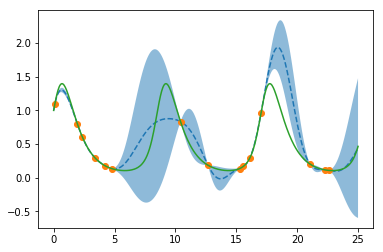

In [4]:
def reset_session():
    """Creates a new global, interactive session in Graph-mode."""
    global sess
    try:
        tf.reset_default_graph()
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession()

reset_session()

lf_length_scales = [1.]
S0 = [[1.]]
D0 = [1.]

kern = LFM1_RBF(D0, S0, lf_length_scales)
lfm = LLFM(kern)

times2 = ttd[ind2]
lfm.t_input = [times2,]

Y = tf.placeholder(name='Y', 
                   shape=(N2, 1), 
                   dtype=np.float64)

lfm = LLFM(kern)
lfm.t_input = [times2, ]
lfm.Y = Y

# Build a tensorflow operator to return the log_likelihood
log_likelihood = lfm._build_likelihood()

# construct an optimiser
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(-log_likelihood)

# specify no. of iterations for model fitting...
# ... and a container for the values
num_iters = 500

feed_dict = {Y: (sol[ind2, 1] - sol[0, 1])[:, None]}
sess.run(tf.global_variables_initializer())

def train(num_iters):
    lls_ = np.zeros(num_iters, np.float64)
    for i in range(num_iters):
        _, lls_[i] = sess.run([train_op, log_likelihood], 
                              feed_dict=feed_dict)
    return lls_

lls_ = train(500)
D, S, lf_length_scales = sess.run([lfm.kernel.D,
                                   lfm.kernel.S,
                                   lfm.kernel.lf_length_scales])

my, Cy = lfm.predict([ttd,])
my += sol[0, 1]

my, Cy = sess.run([my, Cy], feed_dict=feed_dict)
sd = np.sqrt(np.diag(Cy))

fig, ax = plt.subplots()
ax.plot(ttd, my , '--' )
ax.plot(times2, sol[ind2, 1], 'o')
ax.fill_between(ttd, 
                my[:, 0] + 2*sd,
                my[:, 0] - 2*sd, alpha=0.5)
ax.plot(ttd, sol[:, 1], '-')
plt.show()

## 

$$
\begin{align}
\int_0^T e^{D(T-\tau)}e^{-\frac{(\tau-\tau')}{\ell^2}} d \tau =
\frac{1}{2}\sqrt{\pi}\ell &e^{\frac{D}{4}(D\ell^2 + 4T - 4\tau')} \\
&\times \left\{\mathrm{erf}\left(\frac{D \ell}{2} + \frac{T - \tau'}{2\ell}\right) -
\mathrm{erf}\left(\frac{D\ell}{2} - \frac{\tau'}{\ell}\right) \right\}
\end{align}
$$

In [12]:
import sympy

tau_1, tau_2 = sympy.symbols('tau_1 tau_2')
l = sympy.symbols('l')
D_ = sympy.Symbol('D')

expr = sympy.exp(D_*tau_1)*sympy.exp(-(tau_1-tau_2)**2 / l**2)

ky = sympy.integrate(expr, (tau_1))
sympy.pprint(ky)

       ⌠                            
    2  ⎮           2                
 -τ₂   ⎮        -τ₁    2⋅τ₁⋅τ₂      
 ───── ⎮        ─────  ───────      
    2  ⎮           2       2        
   l   ⎮  D⋅τ₁    l       l         
ℯ     ⋅⎮ ℯ    ⋅ℯ     ⋅ℯ        d(τ₁)
       ⌡                            
